In [349]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from pyro.infer.mcmc.util import summary
from palmerpenguins import load_penguins
plt.style.use('ggplot')

# Chapter 3

In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [ ]:
penguins

In [3]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [ ]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [ ]:
#  prior predictive --> mu and sigma
samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

In [ ]:
az.plot_density(data=samples['mass'].numpy())

In [ ]:
az.plot_density(data=samples['mu'].numpy())

In [ ]:
az.plot_density(data=samples['sigma'].numpy())

In [ ]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

In [ ]:
mcmc.summary()

In [ ]:
samples_1 = mcmc.get_samples()

In [ ]:
samples_1

## 3.2.1 Linear Penguins

In [4]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [ ]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [ ]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

### MCMC

- `mcmc` = fitted MCMC object
- `mcmc_samples` = only the latent variables are returned via the `.get_samples()` method
    - `mu` is not returned in the `mcmc.get_samples()` dict
    - deterministic parts are only available via the `Predictive` function. Similarily, observed samples is only available via this function too 

In [ ]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    
    return site_stats

In [ ]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc_simple = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_simple.run(flipper_length=adelie_flipper_length, mass=adelie_mass)

In [ ]:
mcmc_simple.summary()

In [ ]:
# trace plots are interesting for only only chain
az.plot_trace(az.from_pyro(mcmc_simple))
plt.tight_layout()

#### Posterior Predictive Distribution

Sample mass and mu from posterior. 

In [ ]:
# latent variables
mcmc_samples = mcmc_simple.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# latent variables: 
predictive_samples = predictive(flipper_length=adelie_flipper_length, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

In [ ]:
def mcmc_fit(predictive):
    mass = predictive['mass']
    mass_mu = mass.mean(axis=0)
    mass_std = mass.std(axis=0)

    mass_df = pd.DataFrame({
        'feat': adelie_flipper_length,
        'mean': mass_mu,
        'high': mass_mu + mass_std,
        'low': mass_mu - mass_std}
    )

    return mass_df.sort_values(by=['feat'])

In [ ]:
mass_df = mcmc_fit(predictive=predictive_samples)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
plt.plot(mass_df['feat'], mass_df['mean'], color='black')
plt.fill_between(
    mass_df['feat'], mass_df['high'], mass_df['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### Stochastic Variational Inference (SVI)

Using SVI for a simple linear regression like this is probably overkill, but lets do it anyways.

For the surrogate, we use the predefined `AutoNormal`

**NOT WORKING: I believe it has to do with the autoguide. Solution could be to implement the guide by hand**

In [ ]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [ ]:
def guide(flipper_length, mass=None):

    sigma_loc = pyro.param(
        'sigma_loc', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_0_loc = pyro.param(
        'beta_0_loc', lambda: torch.tensor(0.))
    beta_0_scale = pyro.param(
        'beta_0_scale', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_1_loc = pyro.param('beta_1_loc', lambda: torch.randn(1))
    beta_1_scale = pyro.param(
        'beta_1_scale', lambda: torch.ones(1), constraint=constraints.positive)
    

    sigma = pyro.sample('sigma', dist.HalfNormal(sigma_loc, torch.tensor(0.05)))
    beta_0 = pyro.sample('beta_0', dist.Normal(beta_0_loc, beta_0_scale))
    beta_1 = pyro.sample('beta_1', dist.Normal(beta_1_loc, beta_1_scale))

    return {'beta_0': beta_0, 'beta_1': beta_1, 'sigma': sigma}

In [ ]:
pyro.render_model(
    guide, 
    model_args=(adelie_flipper_length, adelie_mass_obs), 
    render_params=True
    )

In [ ]:
custom_guide = guide(linear_model)
custom_guide

In [ ]:
auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
auto_guide

In [ ]:
pyro.clear_param_store()

# These should be reset each training loop
#auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
adam = pyro.optim.Adam({'lr': 0.005})
elbo = pyro.infer.Trace_ELBO()
svi = SVI(linear_model, custom_guide, adam, elbo)

losses = []
for step in range(2001): 
    loss = svi.step(adelie_flipper_length, adelie_mass)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

pyro.get_param_store() is comprised of learned parameters that will be used in the `Predictive` stage. Instead of providing samples, the `guide` parameter is used to construct the posterior predictive distribution

In [ ]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
auto_guide.quantiles([0.25, 0.5, 0.75])

In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
        
    return site_stats

In [ ]:
predictive = Predictive(linear_model, guide=auto_guide, num_samples=1000)
svi_samples = predictive(adelie_flipper_length, mass=None)
svi_mass = svi_samples['mass']

In [ ]:
mcmc_fit(predictive=svi_samples)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), np.exp(adelie_mass.numpy()), alpha=0.5)
#plt.plot(adelie_flipper_length.numpy(), svi_mass.mean(axis=0))
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

## 3.3 Multiple Linear Regression

In [ ]:
sex_obs = torch.from_numpy(penguins.loc[adelie_mask, 'sex'].replace({'male': 0, 'female': 1}).values)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.show()

In [ ]:
def linear_model(flipper_length, sex, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 3000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 3000.))
    beta_2 = pyro.sample('beta_2', dist.Normal(0., 3000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length + beta_2 * sex)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [ ]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, sex_obs, adelie_mass),
    render_distributions=True
    )

In [ ]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300, num_chains=1)
mcmc.run(flipper_length=adelie_flipper_length, sex=sex_obs, mass=adelie_mass)

In [ ]:
mcmc.summary()

In [ ]:
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()

In [ ]:
# latent variables
mcmc_samples = mcmc.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(flipper_length=adelie_flipper_length, sex=sex_obs, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

In [ ]:
mass_mu = predictive_samples['mass'].numpy().mean(axis=0)
mass_std = predictive_samples['mass'].numpy().std(axis=0)

predictions = pd.DataFrame({
    'sex': sex_obs,
    'flipper': adelie_flipper_length,
    'mass_mu': mass_mu,
    'mass_std': mass_std,
    'high': mass_mu + mass_std,
    'low': mass_mu - mass_std
})

predictions = predictions.sort_values(by=['flipper'])

In [ ]:
male = predictions[predictions['sex'] == 0]
female = predictions[predictions['sex'] == 1]

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.plot(male['flipper'], male['mass_mu'])
plt.plot(female['flipper'], female['mass_mu'])
plt.fill_between(
    male['flipper'], male['high'], male['low'], alpha=0.2, color='grey')
plt.fill_between(
    female['flipper'], female['high'], female['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('Predictions $\pm 1 \sigma$ ')
plt.show()

In [ ]:
mcmc_multiple_az = az.from_pyro(mcmc)
mcmc_simple_az = az.from_pyro(mcmc_simple)

az.plot_forest([mcmc_simple_az, mcmc_multiple_az], var_names=['sigma'])
# manually specify to avoid confusion
plt.legend(['flipper_x_sex $\sigma$', 'flipper_only $\sigma$'])
plt.show()

### Counterfactuals

## Generalized Linear Models

### Logistic Regression

In [7]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
bill_length_obs = torch.from_numpy(penguins.loc[species_filter, 'bill_length_mm'].values)
species = pd.Categorical(penguins.loc[species_filter, 'species'])
species_codes = torch.from_numpy(species.codes).to(torch.float64)

In [78]:
def logistic_model(bill_length, species=None):

    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.))
    mu = beta_0 + torch.mul(beta_1, bill_length) ## support broadcasting to common shape
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    db = pyro.deterministic('db', -beta_0 / beta_1)

    with pyro.plate('plate'):
        y1 = pyro.sample('y1', dist.Bernoulli(theta), obs=species)

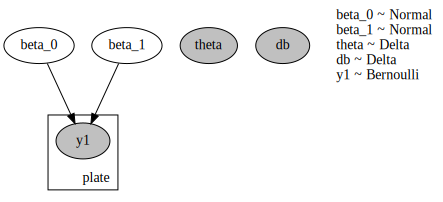

In [79]:
# we don't observe theta or db
pyro.render_model(
    logistic_model, 
    model_args=(bill_length_obs, species_codes),
    render_distributions=True)

In [80]:
kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc_logistic = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_logistic.run(bill_length=bill_length_obs, species=species_codes)

Sample: 100%|██████████| 800/800 [00:15, 51.64it/s, step size=1.79e-01, acc. prob=0.937] 


In [16]:
mcmc_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    -33.86      3.88    -34.08    -39.15    -26.50    100.12      1.00
    beta_1      0.77      0.09      0.77      0.60      0.89     99.96      1.00

Number of divergences: 0


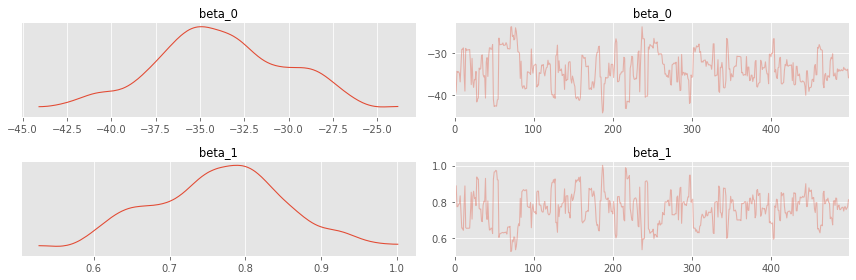

In [17]:
az.plot_trace(az.from_pyro(mcmc_logistic))
plt.tight_layout()

In [18]:
# latent variables
mcmc_samples = mcmc_logistic.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(logistic_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(bill_length_obs, None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

y1: (1000, 214)
theta: (1000, 1, 214)
db: (1000, 1)


In [19]:
prob_mu = predictive_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = predictive_samples['theta'].numpy().std(axis=0).flatten()
db_mu = predictive_samples['db'].numpy().mean()
db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs,
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

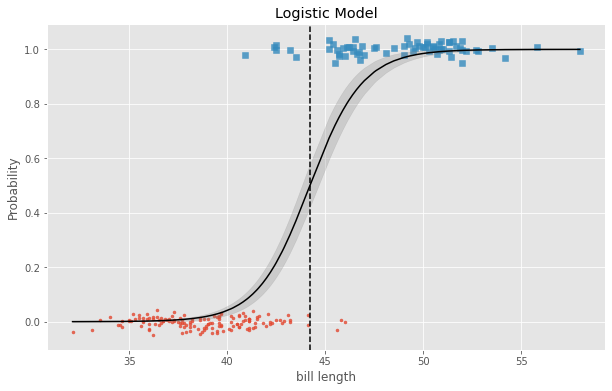

In [35]:
plt.figure(figsize=(10, 6))

for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i) ## size
    x = bill_length_obs[_filter] ## x_obs
    y = np.random.normal(i, 0.02, size=_filter.sum()) ## small amount of noise (jitter)
    plt.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

plt.plot(predictions['bill_length'], predictions['prob_mu'], color='black')
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
plt.axvline(
    x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model')
plt.show()

In [38]:
logistic_az = az.from_pyro(posterior=mcmc_logistic)

#### Code 3.23

Use body mass as a covariate

#### Code 3.24

Using body mass **and** flipper length as covariates

When creating a multidimensional distribution in pyro, there is the added functionality of `.to_event(1)`. This method implies that "these dimensions should be treated as a single event".
- see discussion [here](https://forum.pyro.ai/t/understanding-when-to-use-to-event-in-vae-tutorial/2380) 

In [392]:
dist.Normal(0., 20.).expand([2]).to_event(1)

Independent(Normal(loc: torch.Size([2]), scale: torch.Size([2])), 1)

In [412]:
X = penguins.loc[species_filter, ['bill_length_mm', 'body_mass_g']]
#X.insert(0, 'intercept', value=1)
X = torch.from_numpy(X.values)
species_codes = species_codes.reshape(-1, 1)

In [409]:
def multiple_logistic_model(data_matrix, species=None):

    N, K = data_matrix.size()

    beta = pyro.sample("b", dist.Normal(0, 10))
    w = pyro.sample('coef', dist.Normal(0., 20.).expand([K]))
    #w = pyro.sample('coef', dist.Normal(torch.zeros(K), torch.ones(K)))

    mu = beta + torch.mul(data_matrix, w)
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    #db = pyro.deterministic('db', ((-w[0] / w[2]) - (w[1] / w[2])) * data_matrix[:, 1])

    with pyro.plate('plate'):
        y1 = pyro.sample('obs', dist.Bernoulli(theta), obs=species)

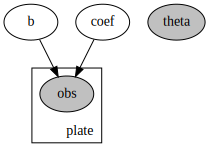

In [410]:
pyro.render_model(
    multiple_logistic_model, model_args=(X, species_codes)
    )

In [411]:
kernel = NUTS(model=multiple_logistic_model, adapt_step_size=True)
mcmc_mult_logistic = MCMC(kernel, num_samples=1200, warmup_steps=500)
mcmc_mult_logistic.run(X, species_codes)

Sample: 100%|██████████| 1700/1700 [01:59, 14.26it/s, step size=6.14e-02, acc. prob=0.897]


In [413]:
mcmc_mult_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b    -34.76      4.35    -34.55    -41.63    -27.85    141.82      1.00
   coef[0]      0.79      0.10      0.78      0.63      0.95    140.80      1.00
   coef[1]    -15.17     11.09    -13.01    -31.11     -0.10    111.52      1.00

Number of divergences: 617


In [414]:
mcmc_mult_samples = mcmc_mult_logistic.get_samples(num_samples=1000)
post_predictive = Predictive(multiple_logistic_model, mcmc_mult_samples)
predictive_samples = post_predictive(X, None)

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

obs: (1000, 214, 2)
theta: (1000, 1, 214, 2)


In [415]:
inf_data = az.from_pyro(
    mcmc_mult_logistic,
    posterior_predictive=mcmc_mult_samples
)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.
posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


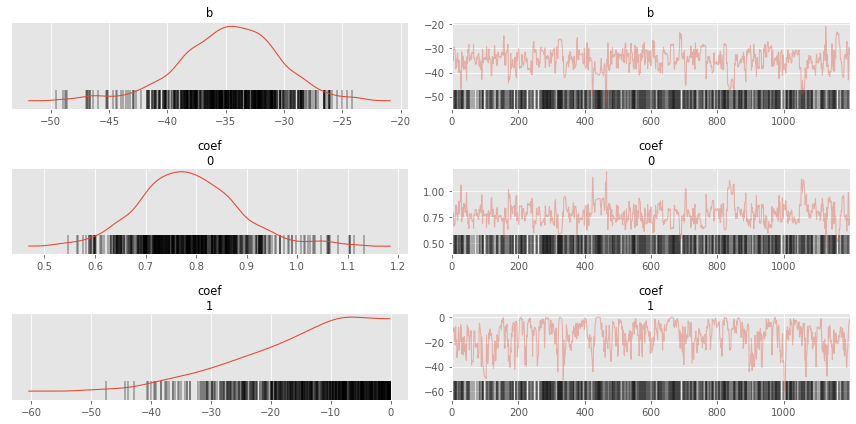

In [417]:
az.plot_trace(inf_data, compact=False, var_names=['b', 'coef'])
plt.tight_layout()
plt.show()

In [418]:
az.summary(inf_data, var_names=['b', 'coef'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,-34.760,4.353,-43.085,-26.459,0.364,0.264,153.0,118.0,NaN
coef[0],0.786,0.100,0.588,0.966,0.008,0.006,152.0,120.0,NaN
coef[1],-15.167,11.087,-35.278,-0.075,1.045,0.741,110.0,170.0,NaN


In [421]:
prob_mu = predictive_samples['theta'].mean(axis=0)[0][:, 0]
prob_std = predictive_samples['theta'].std(axis=0)[0][:, 0]
#db_mu = predictive_samples['db'].numpy().mean()
#db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': X[:, 0].numpy(),
    'mass': X[:, 1].numpy(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length', 'mass'])

In [422]:
predictions

,bill_length,mass,prob_mu,prob_std,high,low
136,32.1,3050.0,0.000130,0.000175,0.000306,-0.000045
92,33.1,2900.0,0.000262,0.000311,0.000573,-0.000050
64,33.5,3600.0,0.000346,0.000392,0.000739,-0.000046
86,34.0,3400.0,0.000493,0.000524,0.001017,-0.000031
13,34.4,3325.0,0.000654,0.000661,0.001315,-0.000006
...,...,...,...,...,...,...
175,52.8,4550.0,0.998175,0.001934,1.000109,0.996241
185,53.5,4500.0,0.998884,0.001293,1.000178,0.997591
177,54.2,4300.0,0.999316,0.000866,1.000182,0.998450
209,55.8,4000.0,0.999773,0.000348,1.000122,0.999425


In [328]:
predictive_samples["db"].reshape(-1, 214)

tensor([[-0.0729, -0.0732, -0.0738,  ..., -0.0800, -0.0808, -0.0804],
        [-0.1558, -0.1564, -0.1575,  ..., -0.1707, -0.1724, -0.1715],
        [-0.0372, -0.0374, -0.0376,  ..., -0.0404, -0.0408, -0.0406],
        ...,
        [-0.0652, -0.0655, -0.0661,  ..., -0.0738, -0.0747, -0.0742],
        [-0.0341, -0.0342, -0.0344,  ..., -0.0367, -0.0370, -0.0368],
        [-0.1524, -0.1531, -0.1545,  ..., -0.1709, -0.1730, -0.1720]],
       dtype=torch.float64)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


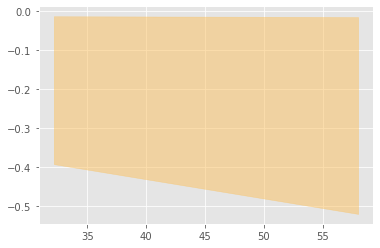

In [329]:
az.plot_hdi(X[:,1], predictive_samples["db"].reshape(-1, 214), color='C4')